### <span style="color:rgb(92,29,79)">Optimization for Machine Learning - Stochastic gradient methods</span>
### <span style="color:rgb(92,29,79)">Master 2 IASD & Master 2 MASH, 2021-2022</span>

# <span style="color:rgb(92,29,79)">Lab 02 - Advanced stochastic gradient techniques</span>



Lecture notes for this course are available [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/SG/LectureNotesOML-SG.pdf).

This Jupyter notebook can be obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/SG/SourcesLabSG02.zip).

For any comment regarding this notebook (including typos), please send an email to: **clement.royer@dauphine.psl.eu**.

## <span style="color:rgb(92,29,79)">Introduction</span>

The goal of this lab session is to implement several variants of the stochastic gradient method. As in the previous lab session, we will try those on two different regression problems that possess a finite-sum structure. We mainly focus on algorithms that possess variance reduction capabilities, as well as popular variants in deep learning frameworks.

In addition to the implementation part, several questions are given to stimulate discussion on the main concepts that have been addressed in the lectures.

In [1]:
# Preamble: useful toolboxes, librairies, functions, etc.

%matplotlib inline
import matplotlib.pyplot as plt

from numba import njit, jit, jitclass  # A just in time compiler to accelerate the calculation

from math import sqrt # Square root

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn # Probability distributions on vectors

# SciPy - Efficient mathematical calculation
from scipy.linalg.special_matrices import toeplitz # A special kind of matrices
from scipy.linalg import svdvals # Singular values
from scipy.linalg import norm # Euclidean norm
from scipy.optimize import check_grad # Check accuracy between objective and gradient values
from scipy.optimize import fmin_l_bfgs_b # Efficient optimizer

from sklearn.model_selection import train_test_split # Only for spliting data
import pandas as pd # To persist results in a csv 

# <span style="color:rgb(92,29,79)">Part 1 - Data Splitting and finite-sum problems</span>

## <span style="color:rgb(92,29,79)">1.1 Importing and spliting data</span>

In this section I will split the dataset of 5 variables obtained via PCA in the notebook Exploratory Data Analysis into test and training set. We are going to encode the electron neutrinos as -1 and the muon nutrinos as +1

In [2]:
# Import variables
data = pd.read_csv("./data/reduced_pca_5.csv")

# Add label to the dataset, the first 36499 are electron neutrinos (-1 class) and the others 96565 are muon neutrinos (+1)
# Seperate neutrinos from electrons and muons
electron = data.head(36499)
muon = data.tail(96565)

del data

electron["neutrino"] = -1
muon["neutrino"] = 1

data = electron.append(muon)

del electron
del muon

In [3]:
# Create small portion of data to be able to compute SGD in feasable time
electron = data.head(500)
muon = data.tail(500)

data_sgd = electron.append(muon)

del electron
del muon

In [7]:
# Splitting Train and test set
X = data.iloc[:,0:5]
y = data["neutrino"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Convert to numpy array
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [4]:
# Data from SGD is not going to be splitted in to train and test set, because we are going to use batch gradient descent for evaluating the model (This will be explained in the report)

X_sgd = data_sgd.iloc[:,0:5]
y_sgd = data_sgd["neutrino"]

# Convert to numpy array
X_sgd = X_sgd.to_numpy()
y_sgd = y_sgd.to_numpy()

### <span style="color:rgb(92,29,79)"> Regression models</span>

We implement a generic regression problem encoding both linear and logistic regression tasks.

- In linear regression, our model is linear and the loss is the least-squares (or $\ell_2$ loss). We thus have
$$
    f(\mathbf{w}) = \frac{1}{2 n} \|\mathbf{X} \mathbf{w} - \mathbf{y}\|^2 + \frac{\lambda}{2}\|\mathbf{w}\|^2, 
    \quad
    f_i(\mathbf{w}) = \frac{1}{2} (\mathbf{x}_i^T \mathbf{w} - y_i)^2 + \frac{\lambda}{2} \|\mathbf{w}\|^2.
$$

- In logistic regression, our goal is to classify correctly the data points. Our model is still linear but we now consider a sigmoid loss:
$$
    f(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^n f_i(\mathbf{w}), \quad 
    f_i(\mathbf{w}) = \log(1+\exp(-y_i \mathbf{x}_i^T \mathbf{w}))+\frac{\lambda}{2}\|\mathbf{w}\|^2.
$$

In [5]:
# Python class for regression problems
class RegPb(object):
    '''
        A class for regression problems with linear models.
        
        Attributes:
            X: Data matrix (features)
            y: Data vector (labels)
            n,d: Dimensions of X
            loss: Loss function to be considered in the regression
                'l2': Least-squares loss
                'logit': Logistic loss
            lbda: Regularization parameter
    '''
   
    # Instantiate the class
    def __init__(self, X, y,lbda=0,loss='l2'):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.loss = loss
        self.lbda = lbda
        
    
    # Objective value
    def fun(self, w):
        if self.loss=='l2':
            return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.
        elif self.loss=='logit':
            yXw = self.y * self.X.dot(w)
            return np.mean(np.log(1. + np.exp(-yXw))) + self.lbda * norm(w) ** 2 / 2.
    
    # Partial objective value
    def f_i(self, i, w):
        if self.loss=='l2':
            return norm(self.X[i].dot(w) - self.y[i]) ** 2 / (2.) + self.lbda * norm(w) ** 2 / 2.
        elif self.loss=='logit':
            yXwi = self.y[i] * np.dot(self.X[i], w)
            return np.log(1. + np.exp(- yXwi)) + self.lbda * norm(w) ** 2 / 2.
    
    # Full gradient computation
    def grad(self, w):
        if self.loss=='l2':
            return self.X.T.dot(self.X.dot(w) - self.y) / self.n + self.lbda * w
        elif self.loss=='logit':
            yXw = self.y * self.X.dot(w)
            aux = 1. / (1. + np.exp(yXw))
            return - (self.X.T).dot(self.y * aux) / self.n + self.lbda * w
    
    # Partial gradient
    def grad_i(self,i,w):
        x_i = self.X[i]
        if self.loss=='l2':
            return (x_i.dot(w) - self.y[i]) * x_i + self.lbda*w
        elif self.loss=='logit':
            grad = - x_i * self.y[i] / (1. + np.exp(self.y[i]* x_i.dot(w)))
            grad += self.lbda * w
            return grad
        
    # Partial gradient knowing the model (useful for certain gradient techniques)
    def grad_xi(self,i,xiw,w=None):
        x_i = self.X[i]
        if self.loss=='l2':
            grad = (xiw - self.y[i]) * x_i 
            if (self.lbda>0):
                grad += self.lbda*w
        elif self.loss=='logit':
            grad = - x_i * self.y[i] / (1. + np.exp(self.y[i]* xiw))
            if (self.lbda>0):
                grad += self.lbda * w
        return grad        

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        elif self.loss=='logit':
            L = norm(self.X, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L
    
    # ''Strong'' convexity constant (could be zero if self.lbda=0)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.X)
            mu = min(s)**2 / self.n 
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda

In [15]:
########### FOR GRADIENT DESCENT ################
d = 5
n = 93144

idx = np.arange(d)
lbda = 1. / n ** (0.5)


# Fix random seed for reproducibility
np.random.seed(1)

# Ground truth coefficients of the model
w_model_truth = (-1)**idx * np.exp(-idx / 10.)


pblogreg = RegPb(X_train, y_train, lbda, loss='logit')

In [6]:
########### FOR STOCHASTIC GRADIENT DESCENT ################
d = 5
n = 1000

idx = np.arange(d)
lbda = 1. / n ** (0.5)


# Fix random seed for reproducibility
np.random.seed(1)

# Ground truth coefficients of the model
w_model_truth = (-1)**idx * np.exp(-idx / 10.)


pblogreg = RegPb(X_sgd, y_sgd, lbda, loss='logit')

In this lab, we work with relatively simple loss functions: we can thus efficiently compute a solution using a second-order method (see the upcoming lecture by Matthieu Blondel). This provides us with a target objective value as well as a target vector of weights.

In [8]:
# Use L-BFGS-B to determine a solution for both problems

w_init = np.zeros(d)

# Compute the optimal solution for logistic regression
w_min_log, f_min_log, _ = fmin_l_bfgs_b(pblogreg.fun, w_init, pblogreg.grad, args=(), pgtol=1e-30, factr =1e-30)

print(f_min_log)
print(norm(pblogreg.grad(w_min_log)))

0.681520132288291
3.074185839272651e-11


These solutions will enable us to study the behavior of the distance to optimality in terms of function values 
$f(\mathbf{w}_k)-f^*$ (we will also record the values $\|\mathbf{w}_k -\mathbf{w}^*\|$). 


# <span style="color:rgb(92,29,79)">Part 2 - Variants on the stochastic gradient framework</span>

The goal of this section is to present popular variants of the classical stochastic gradient scheme. The following implementation will be used throughout.

In [9]:
# Stochastic gradient implementation
def stoch_grad(w0,problem,wtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,average=0,scaling=0,with_replace=False,verbose=False): 
    """
        A code for gradient descent with various step choices.
        
        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            wtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size 
                1: Classical stochastic gradient algorithm (default value)
                problem.n: Classical gradient descent (default value)
            average: Indicates whether the method computes the average of the iterates 
                0: No averaging (default)
                1: With averaging
            scaling: Use a diagonal scaling
                0: No scaling (default)
                1: Average of magnitudes (RMSProp)
                2: Normalization with magnitudes (Adagrad)
            with_replace: Boolean indicating whether components are drawn with or without replacement
                True: Components drawn with replacement
                False: Components drawn without replacement (Default)
            verbose: Boolean indicating whether information should be plot at every iteration (Default: False)
            
        Outputs:
            w_output: Final iterate of the method (or average if average=1)
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    w = w0.copy()
    nw = norm(w)
    
    # Average (if needed)
    if average:
            wavg=np.zeros(len(w))
    
    #Scaling values
    if scaling>0:
        mu=1/(2 *(n ** (0.5)))
        v = np.zeros(d)
        beta = 0.8

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(w) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)
    
    # Plot initial quantities of interest
    if verbose:
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nw < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],w)
            sg = sg + gi
        sg = (1/nb)*sg
        
        if scaling>0:
            if scaling==1:
                # RMSProp update
                v = beta*v + (1-beta)*sg*sg
            elif scaling==2:
                # Adagrad update
                v = v + sg*sg 
            sg = sg/(np.sqrt(v+mu))
            
        if stepchoice==0:
            w[:] = w - (1/L) * sg
        elif stepchoice==1:
            sk = float(step0/(sqrt(k+1)))
            w[:] = w - sk * sg
        
        nw = norm(w) #Computing the norm to measure divergence 
        
        if average:
            # If average, compute the average of the iterates
            wavg = k/(k+1) *wavg + w/(k+1) 
            nmin = norm(wavg-wtarget)
            obj = problem.fun(wavg)
        else:
            obj = problem.fun(w)
            nmin = norm(w-wtarget)
        
       
        
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))     
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    if average:
        w_output = wavg.copy()
    else:
        w_output = w.copy()
    
    return w_output, np.array(objvals), np.array(normits)

## <span style="color:rgb(92,29,79)">2.1 Batch methods and variance reduction</span>

The iteration of stochastic gradient (also called *Stochastic Gradient Descent*, or *SGD*) is given by:

$$
    w_{k+1} = w_k - \alpha_k \nabla f_{i_k}(w_k),
$$

where $i_k$ is drawn at random in $\{1,\dots,n\}$. For the purpose of this lab session, $i_k$ will be drawn uniformly at random.

A more general version of stochastic gradient methods is given by the iteration
$$
    \mathbf{w}_{k+1} = \mathbf{w}_k - \frac{\alpha_k}{|S_k|} \sum_{i \in S_k} \nabla f_i(\mathbf{w}_k)
$$
where $S_k$ is a set of indices drawn uniformly in $\{1,\dots,n\}$. For this lab, the samples will be drawn without replacement, so that $|S_k|=n$ results in a full gradient step, while $|S_k|=1$ corresponds to a basic stochastic gradient step.

*Implementation* *Compare the performance of stochastic gradient with several values for the batch size (and using decreasing stepsizes).*

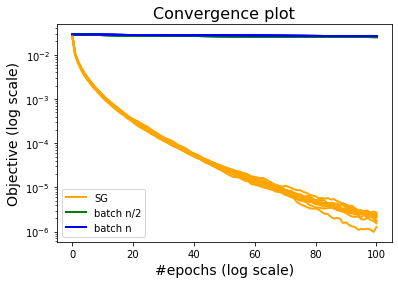

In [9]:
# Test several values for the batch size using the same epoch budget.

nb_epochs = 100
n = pblogreg.n
w0 = np.zeros(d)

nruns = 10

for i in range(nruns):
    # Run standard stochastic gradient (batch size 1)
    _, obj_a, nits_a = stoch_grad(w0,pblogreg,w_min_log,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1,with_replace=True)
    # Batch stochastic gradient (batch size n/10)
    nbset=int(n/2)
    _, obj_b, nits_b = stoch_grad(w0,pblogreg,w_min_log,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=True)
    # Batch stochastic gradient (batch size n, with replacement)
    nbset=n
    _, obj_c, _ = stoch_grad(w0,pblogreg,w_min_log,stepchoice=1,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=True)
    if i<nruns-1:
        plt.semilogy(obj_a-f_min_log,color='orange',lw=2)
        plt.semilogy(obj_b-f_min_log,color='green', lw=2)
        plt.semilogy(obj_c-f_min_log,color='blue', lw=2)
plt.semilogy(obj_a-f_min_log,label="SG",color='orange',lw=2)
plt.semilogy(obj_b-f_min_log,label="batch n/2",color='green', lw=2)
plt.semilogy(obj_c-f_min_log,label="batch n",color='blue', lw=2)    

plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
plt.savefig("./results/figures/different_batch_sizes_sg1.jpg")

In [ ]:
# Saving results in a csv
batch1 = pd.DataFrame({'obj':obj_a, 'nits':nits_a})
batch1["batch_size"] = "batch size 1"
batchn_divided_10 = pd.DataFrame({'obj':obj_b, 'nits':nits_b})
batchn_divided_10["batch_size"] = "batch size n/10"

different_batch_sizes = pd.concat([batch1, batchn_divided_10])
different_batch_sizes.to_csv("./results/SGD_different_batch_sizes.csv")

**Question** ***What property of batch methods is illustrated by the above results?***

**Answer**

In addition to showing that batch methods can converge to better function values, the figure above shows that increasing the batch size reduces the variability of the method across all runs. In that sense, it illustrates 
the *variance reduction* capabilities of batch approaches.

## <span style="color:rgb(92,29,79)">2.2 Stochastic gradient and averaging</span>

**Implementation** Using the input parameter *average*, modify the stochastic gradient code so that it maintains an average of all SG iterates and outputs the last average, as well as the function values and distances to the optimum for the averages.
Validate your implementation using the code below.

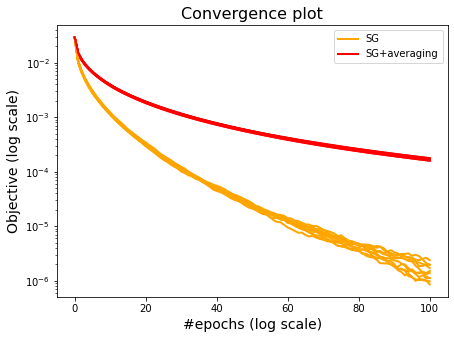

In [10]:
# Comparison of stochastic gradient with and without averaging
nb_epochs = 100
n = pblogreg.n
w0 = np.zeros(d)

nruns = 10

obj_a = np.zeros((nruns,nb_epochs+1))
obj_b = np.zeros((nruns,nb_epochs+1))

for i in range(nruns):
    # Run standard stochastic gradient without averaging
    _, obj_a[i,:], _ = stoch_grad(w0,pblogreg,w_min_log,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1)
    # Run stochastic gradient with averaging
    _, obj_b[i,:], _= stoch_grad(w0,pblogreg,w_min_log,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1,average=1)

# Plot the results
plt.figure(figsize=(7, 5))
for i in range(nruns-1):
    plt.semilogy(obj_a[i,:]-f_min_log,color='orange',lw=2)
    plt.semilogy(obj_b[i,:]-f_min_log,color='red', lw=2)
plt.semilogy(obj_a[-1,:]-f_min_log,label='SG',color='orange',lw=2)
plt.semilogy(obj_b[-1,:]-f_min_log,label='SG+averaging',color='red', lw=2)
    
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
plt.savefig("./results/figures/stochastic_gradient_descent_averaging.jpg")

**Question** ***Give an advantage and a drawback of averaging techniques.***

**Answer**

Averaging the iterates can lead to a smoother behavior in terms of function value and convergence.
However, this process requires to store an additional vector (the average), which is not used in the computation.

##  <span style="color:rgb(92,29,79)">2.3 Popular practical variants based on diagonal scaling</span>

The most successful variants of stochastic gradient, such as *RMSProp* and *Adagrad*, rely on a diagonal scaling of the gradient. This corresponds to rescaling the stochastic gradient step componentwise as follows
 $$
     [\mathbf{w}_{k+1}]_i  = [\mathbf{w}_k]_i -\frac{\alpha}{\sqrt{[\mathbf{v}_k]_i + \mu}}[\nabla f_{i_k}(\mathbf{w}_k)]_i,
 $$ 
 where $\mu>0$ is a regularization parameter, and $\mathbf{v}_k \in \mathbb{R}^d$ is defined recursively by $\mathbf{v}_{-1} = 0_{\mathbb{R}^d}$ and
 $$ 
     \forall k \ge 0,\ \forall i=1,\dots,d, \qquad 
     [\mathbf{v}_k]_i = 
     \left\{
         \begin{array}{ll}
             \beta [\mathbf{v}_{k-1}]_i + (1-\beta) [\nabla f_{i_k}(\mathbf{w}_k)]_i^2 &\mbox{for RMSProp,} \\
             [\mathbf{v}_{k-1}]_i + [\nabla f_{i_k}(\mathbf{w}_k)]_i^2 &\mbox{for Adagrad.}
         \end{array}
     \right.
 $$
(Suggested values: $\mu=\tfrac{1}{2 \sqrt{n}}$, $\beta=0.8$.)

In [10]:
# Comparison of stochastic gradient with and without diagonal scaling

nb_epochs = 60
n = pblogreg.n
w0 = np.zeros(d)

# Stochastic gradient (batch size 1) without diagonal scaling
w_a, obj_a, nits_a = stoch_grad(w0,pblogreg,w_min_log,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Stochastic gradient (batch size 1) with RMSProp diagonal scaling
w_b, obj_b, nits_b = stoch_grad(w0,pblogreg,w_min_log,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1,average=0,scaling=1)
# Stochastic gradient (batch size 1) with Adagrad diagonal scaling - Constant step size
w_c, obj_c, nits_c = stoch_grad(w0,pblogreg,w_min_log,stepchoice=0,step0=0.2, n_iter=nb_epochs*n,nb=1,average=0,scaling=2)
# Stochastic gradient (batch size 1) with Adagrad diagonal scaling - Decreasing step size
w_d, obj_d, nits_d = stoch_grad(w0,pblogreg,w_min_log,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,nb=1,average=0,scaling=2)

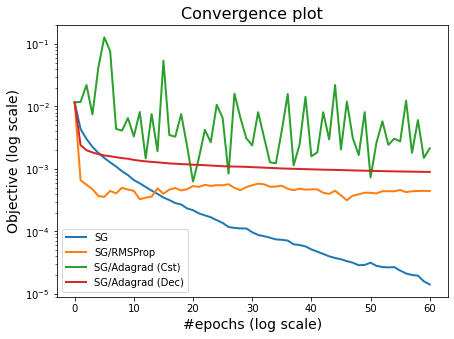

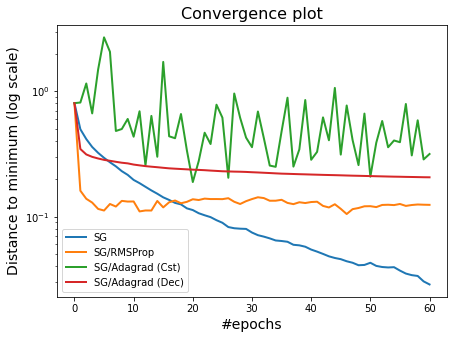

In [11]:
# Plot the results - Comparison of stochastic gradient with and without diagonal scaling
# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_log, label="SG", lw=2)
plt.semilogy(obj_b-f_min_log, label="SG/RMSProp", lw=2)
plt.semilogy(obj_c-f_min_log, label="SG/Adagrad (Cst)", lw=2)
plt.semilogy(obj_d-f_min_log, label="SG/Adagrad (Dec)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
plt.savefig("./results/figures/digonal_scaling.jpg")
# In terms of distance to the minimum (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(nits_a, label="SG", lw=2)
plt.semilogy(nits_b, label="SG/RMSProp", lw=2)
plt.semilogy(nits_c, label="SG/Adagrad (Cst)", lw=2)
plt.semilogy(nits_d, label="SG/Adagrad (Dec)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Distance to minimum (log scale)", fontsize=14)
plt.legend()
plt.savefig("./results/figures/diagonal_scaling2.jpg")

**Question** ***During the lectures, we saw that these two techniques (and Adagrad in particular) accumulate gradient information in a way that gradually reduces the norm of the step. Based on this observation, how can you explain the presence of the quantity $\mu>0$?***

**Answer**

The use of $\mu>0$ prevents the scaling of each component of the stochastic gradient from going to zero. *This technique is typically adopted in modern implementations of these methods.*

# <span style="color:rgb(92,29,79)">Part 3 - Variance reduction methods</span>

In this section, we implement alternative to SGD based on variance reduction principles.

## <span style="color:rgb(92,29,79)">3.1 Stochastic Variance Reduced Gradient (SVRG)</span>

The SVRG method relies on a two-loop recursion:
    
 -  Every outer iteration $k$ begins with a full gradient computation, yielding $\nabla f(\mathbf{w}_k)$; 
 -  The method then performs an inner loop of $m$ iterations starting from $\tilde{\mathbf{w}}_0 = \mathbf{w}_k$; for each iteration of index $j \in \{0,\dots,m-1\}$ within this loop, an index $i_j$ is drawn (uniformly) at random within $\{1,\dots,n\}$ and the method performs the update $\tilde{\mathbf{w}}_{j+1} = \tilde{\mathbf{w}}_j - \alpha \tilde{\mathbf{g}}_j$, where 
 $$\tilde{\mathbf{g}}_j = \nabla f_{i_j}(\tilde{\mathbf{w}}_j) - \nabla f_{i_j}(\mathbf{w}_k) + \nabla f(\mathbf{w}_k).$$
 - At the end of the inner loop, we obtain the next outer iterate by $\mathbf{w}_{k+1} = \tilde{\mathbf{w}}_{m}$.



*Implementation* *Using the above formula, implement the SVRG method with a constant stepsize $\alpha=\frac{0.2}{L}$ 
and a default value of $m=5$.*

In [12]:
# Implementation - Stochastic Variance Reduced Gradient
def svrg(w0,problem,wtarget,n_iter=1000,m=5,verbose=False): 
    """
        A code for stochastic variance reduced gradient (SVRG).
        
        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            wtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            m: length of the inner iteration loop
            verbose: Plot quantities of interest if set to True (default: False)
            
            
        Outputs:
            w_output: Final iterate of the method
            objgap: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    mu = problem.cvxval()
    
    # Number of samples
    n = problem.n
    
    alpha = 0.2/L
    
    
    # Initial value of current iterate  
    w = w0.copy()
    nw = norm(w)

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(w) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)
    
    # Plot initial quantities of interest
    if verbose:
        print("SVRG")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nw < 10**100):
        
        # Compute a full gradient at the beginning of every major iteration
        gwk = problem.grad(w)
        if (k+n)//n > k//n:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)])) 
        
        
        wtilda = w
        wtildavg = w
        
        ######
        # Inner loop
        for j in range(m):
            ij = np.random.choice(n,1,replace=True)
            sg = problem.grad_i(ij[0],wtilda)-problem.grad_i(ij[0],w)+gwk
            wtilda[:] = wtilda - alpha*sg 
            
            if (k+n+j)//n > (k+n)//n:
                objvals.append(obj)
                normits.append(nmin)
                if verbose:
                    print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))  
        # End inner loop
        ######

        w[:] = wtilda.copy()
        nw = norm(w) #Computing the norm to measure divergence 
        obj = problem.fun(w)
        nmin = norm(w-wtarget)
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if k+m+n % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if k+m+n % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    w_output = w.copy()
    return w_output, np.array(objvals), np.array(normits)

## <span style="color:rgb(92,29,79)">3.2 Stochastic Average Gradient (SAG/SAGA)</span>

As seen in class, the SAGA method maintains a sequence of component gradients
$\{\nabla f_i(\mathbf{w}_{[i]})\}$ initializing them with $\nabla f_i(\mathbf{w}_{[i]}) = \nabla f_i(\mathbf{w}_0)$. At every iteration, it then draws an index $i_k$ (uniformly) at random in $\{1,\dots,n\}$ and computes
$$
    \mathbf{g}_k = \nabla f_{i_k}(\mathbf{w}_k) - \nabla f_{i_k}(\mathbf{w}_{[i_k]}) 
    + \frac{1}{n}\sum_{i=1}^n \nabla f_i(\mathbf{w}_{[i]}).
$$
It then performs the following updates:
$$
    \begin{array}{l}
        \mathbf{w}_{k+1}=\mathbf{w}_k-\alpha_k \mathbf{g}_k, \\ 
        \nabla f_{i_k}(\mathbf{w}_{[i_k]}) \leftarrow \nabla f_{i_k}(\mathbf{w}_k).
    \end{array}
$$

**Question:** ***What it the memory cost of such a method? For linear regression, how can we avoid storing all $w_{[i]}$?***

**Answer**

The SAGA method requires to store $n$ vectors in dimension $d$ (one for each component gradient in the sum), which may not be practical in general.

However, for particular cost functions, one may be able to reconstruct the gradients without storing the full vectors. This is the case in linear regression: storing $\mathbf{x}_i^T \mathbf{w}_{[i]}$ (a real value) is sufficient to recover $\nabla f_i(\mathbf{w}_i)$.

*Implementation:* *Implement the SAGA algorithm with a constant stepsize of $\frac{1}{2(\mu n+L)}$.*

In [13]:
# SAGA implementation
def saga(w0,problem,wtarget, n_iter=1000,verbose=False): 
    """
        A code for the SAGA algorithm adapted to work with generalized linear models for which
        
        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.grad_xi() returns the gradient of a single component f_i by taking x_i^T*w as argument
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            wtarget: Target minimum (unknown in practice!)
            n_iter: Number of iterations, used as stopping criterion
            verbose: Plot quantities of interest if set to True (default: False)
            
        Outputs:
            w_output: Final iterate of the method
            objgap: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    # gradient norm history
    normgrads = []
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz and strong convexity constants
    L = problem.lipgrad()
    
    mu = problem.cvxval()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    w = w0.copy()
    nw = norm(w)

    # Initialize iteration counter
    k=0
    
    # Steplength
    alpha = 0.2/(mu*n+L)
    
    # Current objective
    obj = problem.fun(w) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)
    
    # Plot initial quantities of interest
    if verbose:
        print("SAGA")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    
    # Initial gradient calculation
    gavg = np.zeros(d)
    Xw = problem.X.dot(w)
    for i in range(n):
        gavg[:] = gavg + problem.grad_xi(i,Xw[i])
    
    gavg = (1/n)*gavg
    
    ################
    # Main loop
    while (k < n_iter and nw < 10**100):
        
        ik = np.random.choice(n,1,replace=True) # Stochastic gradient (1 component)
        xikw = problem.X[ik].dot(w)
        tp = problem.grad_xi(ik,xikw) - problem.grad_xi(ik,Xw[ik])
        sg = tp + gavg
        gavg = gavg + (1/n) * tp
        Xw[ik]=xikw #Update average
        w[:] = w - alpha * sg
        nw = norm(w) #Computing the norm to measure divergence 
        obj = problem.fun(w)
        nmin = norm(w-wtarget)
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if k % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if k % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    w_output = w.copy()
    return w_output, np.array(objvals), np.array(normits)

*Implementation:* *Run the code below to compare classical stochastic gradient with svrg and saga.*

0.43729302363909867
4.204305410958117e-12


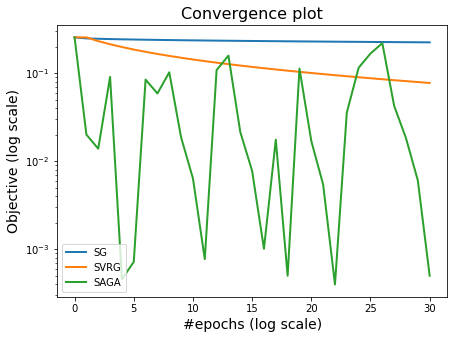

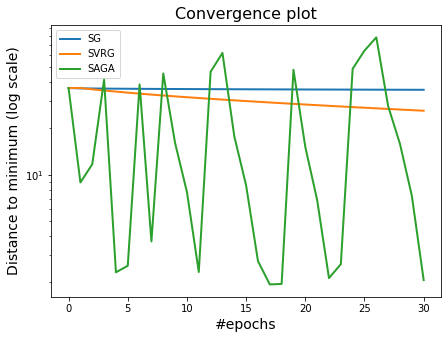

In [14]:
# Compare stochastic gradient with the variance-reduced methods on the linear regression problem

#Xlin, ylin = simu_linmodel(w_model_truth, n, std=1., corr=0.2)
pblogreg = RegPb(X_sgd , y_sgd,lbda=0,loss='logit')
# Compute the optimal solution for linear regression
w_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblogreg.fun, w_init, pblogreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblogreg.grad(w_min_lin)))

nb_epochs = 30
n = pblogreg.n
w0 = np.zeros(d)
m = 5

# Stochastic gradient (batch size 1) without averaging
w_a, obj_a, nits_a = stoch_grad(w0,pblogreg,w_min_lin,stepchoice=1,step0=0.2, n_iter=nb_epochs*n,average=1)
# SVRG
w_b, obj_b, nits_b = svrg(w0,pblogreg,w_min_lin,n_iter=int(nb_epochs*n/(2*m+n)),m=m)
# SAGA
w_c, obj_c, nits_c = saga(w0,pblogreg,w_min_lin,n_iter=nb_epochs*n)

# Plot the results
# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG", lw=2)
plt.semilogy(obj_b-f_min_lin, label="SVRG", lw=2)
plt.semilogy(obj_c-f_min_lin, label="SAGA", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()
# In terms of gradient norm (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(nits_a, label="SG", lw=2)
plt.semilogy(nits_b, label="SVRG", lw=2)
plt.semilogy(nits_c, label="SAGA", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Distance to minimum (log scale)", fontsize=14)
plt.legend()
plt.savefig("./results/figures/SVR_SAGA.jpg")

### Extra work

**SVRG** Try to vary the parameters of SVRG ($m$,$\alpha$). Consider also two alternative techniques for computing $\mathbf{w}_{k+1}$ from $\{\tilde{\mathbf{w}}_j\}_{i=1}^m$:
 - Averaging, i.e. set $\mathbf{w}_{k+1} = \tfrac{1}{m}\sum_{j=1}^m \tilde{\mathbf{w}}_j$;
 - Draw an index $\ell$ uniformly at random in $\{1,\dots,m\}$ and choose $\mathbf{w}_{k+1} = \tilde{\mathbf{w}}_{\ell}$. The resulting implementation should only perform $\ell$ iterations in the inner loop.
 
**Adam** Implement the Adam algorithm as seen in class.


In [ ]:
# Version 1.2 - C. W. Royer, October 2021.